# GO enrichment for retained paralogs example

Here I describe how to get to a GO enrichment analysis for retained paralogs from a WGD event. To this end I use the `wgd` library to perform mixture modeling and select paralogs from a particular mixture component. The GO enrichment is then performed using the `goenrich` library (https://github.com/jdrudolph/goenrich). 

In [38]:
from wgd_cli import mix_
from wgd.viz import plot_selection
from wgd.modeling import mixture_model_bgmm, get_component_probabilities
import matplotlib.pyplot as plt
import pandas as pd
import goenrich

## 1. Get the distributions

The distributions were computed using the '`wgd ks`' and '`wgd syn`' commands from the '`wgd`' CLI.

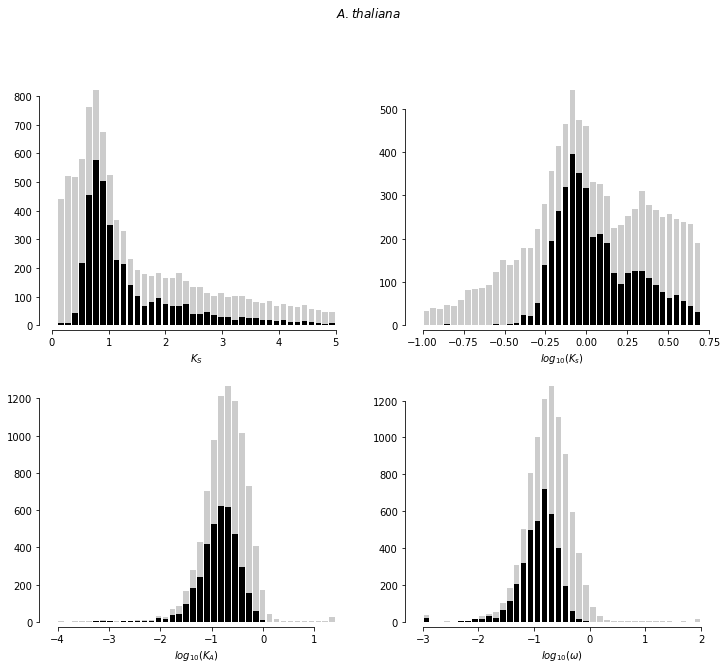

In [72]:
full_ks = pd.read_csv('../test_data/fasttree_ath_aly/wgd_ks/cds.ath.tfa.ks.tsv', sep='\t', index_col=0)
anchors_ks = pd.read_csv('../test_data/fasttree_ath_aly/wgd_syn/cds.ath.tfa.blast.tsv.mcl.ks_anchors.tsv', sep='\t', index_col=0)
plot_selection(dists=[full_ks, anchors_ks], title='$A. thaliana$')
plt.show()

## 2. Mixture modeling

As an illustration I will use th `wgd` library directly here, note however that the '`wgd mix`' command in the `wgd` CLI provides all tools for performing the analysis in this section without the need to code. Use for example the command below:

If all goes correct, you will now have the data frame with for each pair the posterior probability to come from one of the two components. Anyway, I now proceed by performing the analysis directly in the notebook:

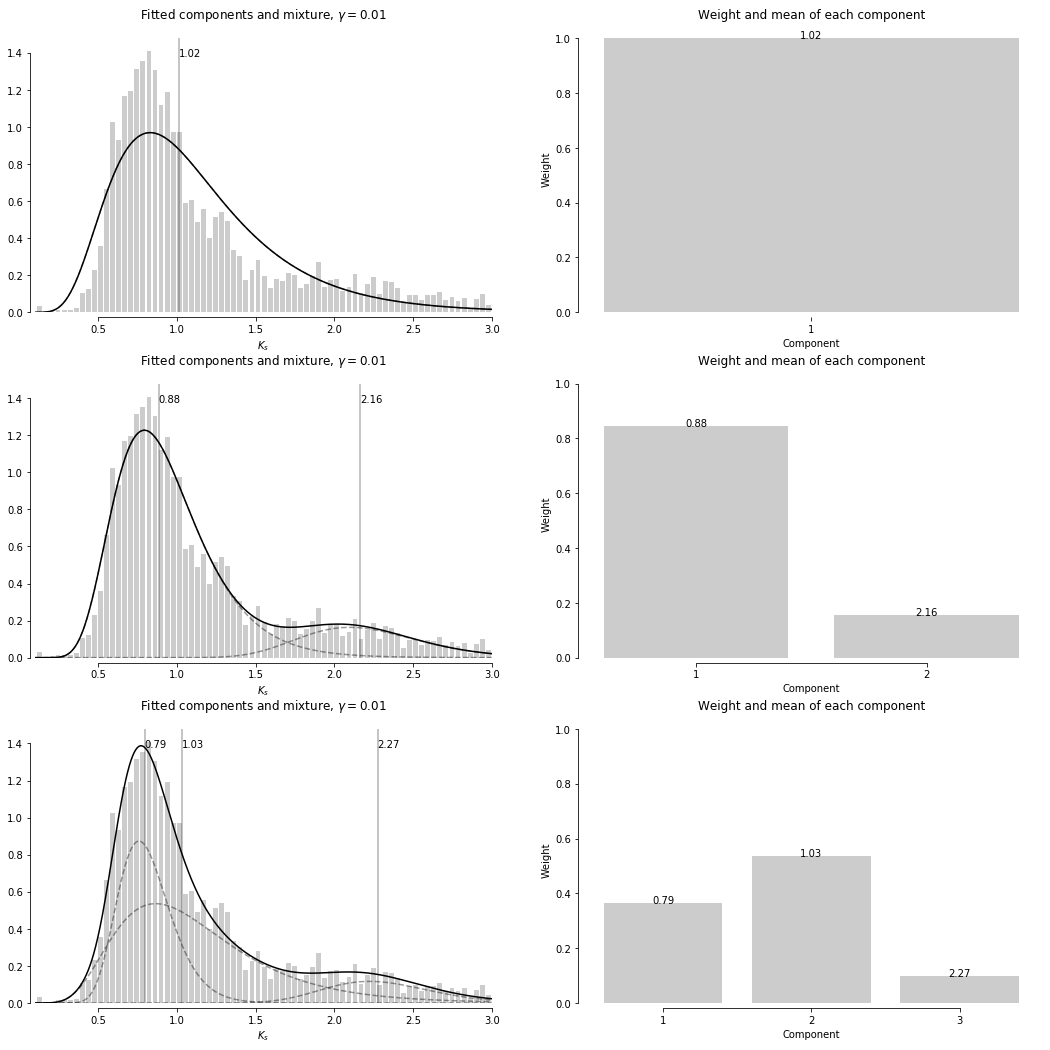

In [20]:
models = mixture_model_bgmm(anchors_ks, n_range=(1,3), Ks_range=(0.1,3), plot_save=False)
plt.show()

It seems more parsimonious to use the two-component model, so I will use that one. I will  now select components from the first component.

In [27]:
model = models[1]
ks_anchors_mix = get_component_probabilities(df=anchors_ks, model=model)
ks_anchors_mix.head()

/home/arzwa/anaconda3/lib/python3.6/site-packages/wgd/modeling.py:407: RuntimeWarning: divide by zero encountered in log
  df['log(Ks)'] = np.log(df['Ks'])


,AlignmentCoverage,AlignmentIdentity,AlignmentLength,AlignmentLengthStripped,Distance,Family,Ka,Ks,Omega,Outlier,Paralog1,Paralog2,WeightOutliersExcluded,WeightOutliersIncluded,log(Ks),p_component1,p_component2
AT2G41210-AT3G56960,0.85588,0.85794,2706.0,1620.0,0.12417,426.0,0.0472,0.6712,0.0704,False,AT2G41210,AT3G56960,1.0,1.0,-0.398688,1.000000,1.690610e-10
AT2G41300-AT3G57010,0.86441,0.67880,1239.0,1071.0,0.55831,2576.0,0.2684,1.5698,0.1710,False,AT2G41300,AT3G57010,0.5,0.5,0.450948,0.766244,2.337556e-01
AT2G41330-AT3G57070,0.73496,0.69054,1596.0,546.0,0.55999,285.0,0.1295,0.7771,0.1667,False,AT2G41330,AT3G57070,1.0,1.0,-0.252186,1.000000,2.122783e-08
AT2G41340-AT3G57080,0.90456,0.74618,723.0,246.0,0.37170,1035.0,0.1612,0.7949,0.2028,False,AT3G57080,AT2G41340,1.0,1.0,-0.229539,1.000000,4.292044e-08
AT2G41370-AT3G57130,0.94715,0.79757,1476.0,1398.0,0.16060,3923.0,0.0829,1.0977,0.0755,False,AT3G57130,AT2G41370,1.0,1.0,0.093217,0.999721,2.791861e-04


In [37]:
paralogs = set(ks_anchors_mix[ks_anchors_mix['p_component1'] > 0.95]['Paralog1'])
paralogs = paralogs | set(ks_anchors_mix[ks_anchors_mix['p_component1'] > 0.95]['Paralog2'])
print('{} paralogs were selected'.format(len(paralogs)))

4863 paralogs were selected


## 3. GO enrichment analysis

I have the genes of interest, _i.e._ the ones I hope to resemble paralogs retained from a WGD represented by the peak I modeled with the Bayesian Gaussian mixture model. Now I will perform GO enrichment on the selected paralogs using the `goenrich` library. To this end I use the whole gene ontology obo graph (retrieved at http://purl.obolibrary.org/obo/go/go-basic.obo and stored in the directory `~/tools/godb/`) and the GO annotatoin for _A. thaliana_ obtained from the GO consortium website (http://geneontology.org/gene-associations/gene_association.tair.gz, also in the directory `~/tools/godb`).

**Set up the GO enrichment analysis**

In [69]:
ontology = goenrich.obo.ontology('/home/arzwa/tools/godb/go-basic.obo')
sgd = goenrich.read.sgd('/home/arzwa/tools/godb/gene_association.tair.gz')
values = {k: set(v) for k,v in gene2go.groupby('go_id')['db_object_name']}
background_attribute = 'sgd'
goenrich.enrich.propagate(ontology, values, background_attribute)

**Perform enrichment analysis and get significant results**

The underlying test is the `hypergeometric test hypergeom.sf(x, M, n, N)`. All $p$-values are corrected for multiple testing using the Benjamini-Hochberge method before a significance cut-off of $\alpha=0.05$ is applied.

In [73]:
df = goenrich.enrich.analyze(ontology, paralogs, background_attribute)
df = df.dropna()
enriched = df[df['rejected'] == 1]

In [82]:
BP = enriched[enriched['namespace'] == 'biological_process']
BP = BP.sort_values('q', ascending=True)
print("There are {} enriched BP terms".format(len(BP)))
BP.head(n=20)

There are 551 enriched BP terms


,M,N,n,name,namespace,p,q,rejected,term,x
21038,38259,4863,390,cellular carbohydrate metabolic process,biological_process,3.436105e-18,1.170462e-15,1.0,GO:0044262,114
9174,38259,4863,339,carbohydrate biosynthetic process,biological_process,2.235509e-17,6.443425e-15,1.0,GO:0016051,102
4217,38259,4863,415,polysaccharide metabolic process,biological_process,7.103715e-17,1.774508e-14,1.0,GO:0005976,116
24774,38259,4863,304,cell development,biological_process,1.761437e-16,3.666724e-14,1.0,GO:0048468,93
6925,38259,4863,312,response to ethylene,biological_process,2.681764e-14,4.785034e-12,1.0,GO:0009723,90
9175,38259,4863,251,carbohydrate catabolic process,biological_process,5.656638e-14,9.634283e-12,1.0,GO:0016052,77
12342,38259,4863,488,root system development,biological_process,2.112954e-13,2.827586e-11,1.0,GO:0022622,121
24700,38259,4863,486,root development,biological_process,3.610757e-13,4.199438e-11,1.0,GO:0048364,120
6955,38259,4863,225,response to jasmonic acid,biological_process,3.623969e-13,4.199438e-11,1.0,GO:0009753,70
532,38259,4863,221,cell morphogenesis involved in differentiation,biological_process,4.402504e-13,4.851819e-11,1.0,GO:0000904,69


$M$ is the total number of genes (background set), $N$ the number of genes in the ste of interest, $n$ the number of genes annotated with the particular term in the background set and $x$ the number of genes with the term of interest annotated in the test set of interest.

Notice how in the top 20 most significant terms many development-related terms appear.